<a href="https://colab.research.google.com/github/Akiyoshi-Yagi/GANs/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#まずは諸々import

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
#モデルの入力次元の設定

img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

#生成器への入力として使われるノイズベクトルの次元
z_dim = 100

In [0]:
#生成器

def build_generator(z_dim):
  model = Sequential()

  model.add(Dense(256*7*7, input_dim = z_dim))
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, kernel_size=3, strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same"))
  model.add(Activation('tanh'))

  return model

In [0]:
#識別器
def build_discriminator(img_shape):

  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization())
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))

  return model

In [0]:
#DCGANコンパイル
def build_gan(generator, discriminator):

  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

generator = build_generator(z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy", optimizer=Adam())

In [0]:
#Training

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  (X_train, _),(_, _) = mnist.load_data()

  X_train = X_train / 127.5 -1.0
  X_train = np.expand_dims(X_train, 3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss,  accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)
    if iteration == 0:
      sample_images(generator)

    if ((iteration + 1) % sample_interval == 0):

      losses.append((d_loss, g_loss))
      accuracies.append(100 * accuracy)
      iteration_checkpoints.append(iteration+1)

      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
      sample_images(generator)

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  gen_imgs = generator.predict(z)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows,
                           image_grid_columns,
                           figsize=(4,4),
                           sharey=True,
                           sharex=True
                           )
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.067762, acc.: 99.22%] [G loss: 3.412722]
2000 [D loss: 0.053202, acc.: 99.61%] [G loss: 4.816056]
3000 [D loss: 0.018835, acc.: 100.00%] [G loss: 3.813987]
4000 [D loss: 0.016799, acc.: 100.00%] [G loss: 5.839272]
5000 [D loss: 0.015656, acc.: 100.00%] [G loss: 3.487003]
6000 [D loss: 0.106420, acc.: 96.88%] [G loss: 3.816822]
7000 [D loss: 0.006411, acc.: 100.00%] [G loss: 5.113606]
8000 [D loss: 0.016447, acc.: 99.61%] [G loss: 6.484900]
9000 [D loss: 0.026451, acc.: 100.00%] [G loss: 6.184054]
10000 [D loss: 0.001595, acc.: 100.00%] [G loss: 7.106216]
11000 [D loss: 0.133551, acc.: 95.70%] [G loss: 4.464504]
12000 [D loss: 0.002511, acc.: 100.00%] [G loss: 10.561480]
13000 [D loss: 0.005886, acc.: 100.00%] [G loss: 8.237690]
14000 [D loss: 0.001121, acc.: 100.00%] [G loss: 9.354071]
15000 [D loss: 0.001757, acc.: 100.00%] [G loss: 8.284821]
16000 [D loss: 0.017143, acc.: 99.61%] [G loss: 8.354351]
17000 [D loss: 0.000679, acc.: 100.00%] [G loss: 7.708495]
18000 [D lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


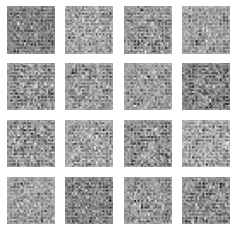

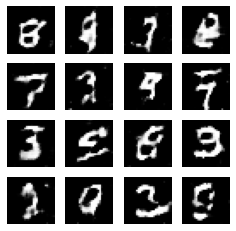

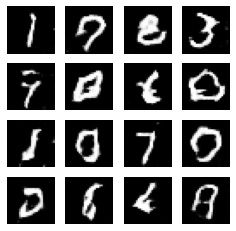

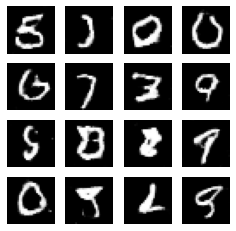

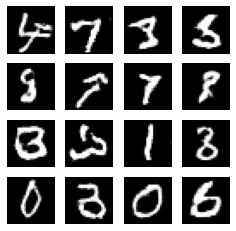

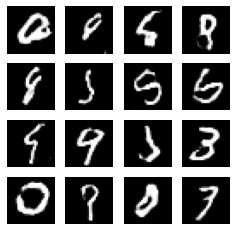

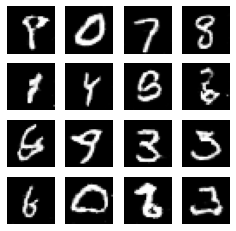

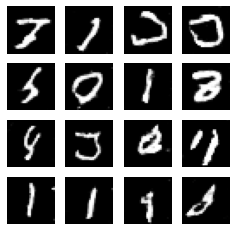

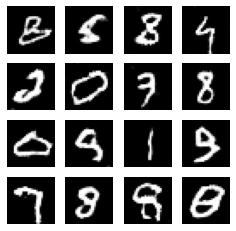

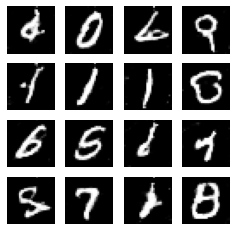

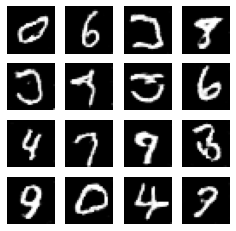

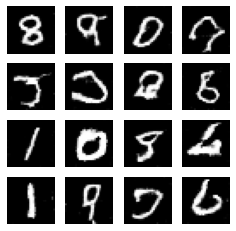

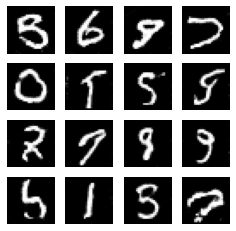

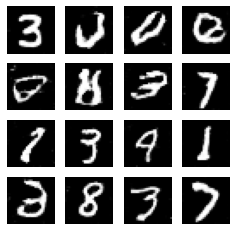

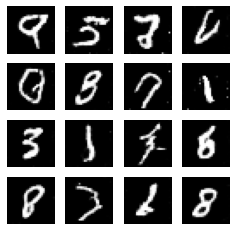

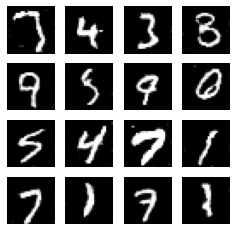

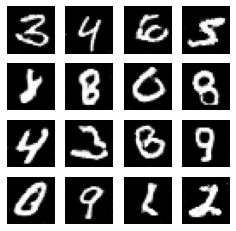

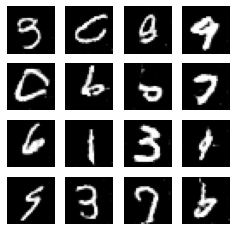

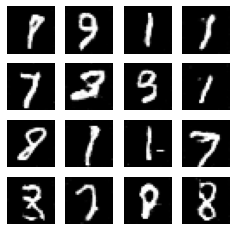

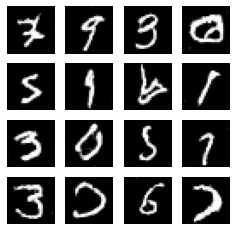

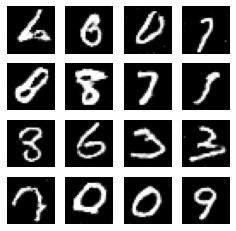

In [22]:
iterations = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)

In [23]:
losses

[(0.06776194, 3.4127219),
 (0.053201757, 4.816056),
 (0.018835489, 3.8139875),
 (0.016799495, 5.8392725),
 (0.015655566, 3.4870028),
 (0.10641967, 3.8168216),
 (0.006410703, 5.1136065),
 (0.016446562, 6.4849),
 (0.026450748, 6.1840544),
 (0.0015952509, 7.1062164),
 (0.13355133, 4.464504),
 (0.0025108913, 10.56148),
 (0.005885684, 8.23769),
 (0.0011206619, 9.354071),
 (0.0017572612, 8.284821),
 (0.01714328, 8.354351),
 (0.00067919574, 7.7084947),
 (0.013819734, 9.608514),
 (0.003354133, 6.8624644),
 (0.00084089604, 9.686069)]

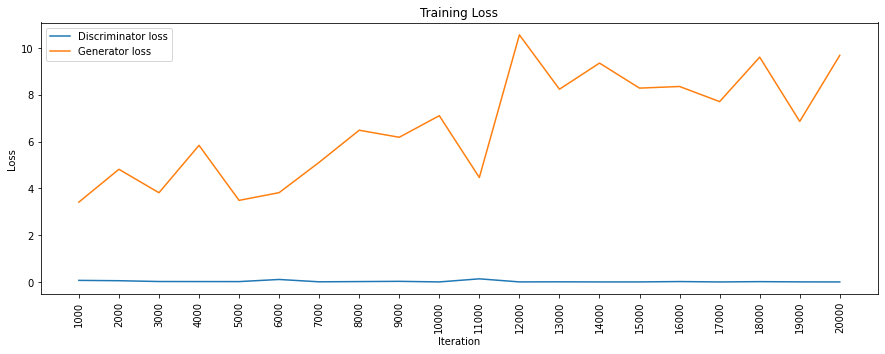

In [25]:
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()